In [3]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os


def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 10
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss(size_average=False)


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.item() / len(img)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 184.330032
Train Epoch: 0 [12800/60000 (21%)]	Loss: 47.414776
Train Epoch: 0 [25600/60000 (43%)]	Loss: 43.721718
Train Epoch: 0 [38400/60000 (64%)]	Loss: 39.970551
Train Epoch: 0 [51200/60000 (85%)]	Loss: 37.606651
Train Epoch: 1 [0/60000 (0%)]	Loss: 37.883759
Train Epoch: 1 [12800/60000 (21%)]	Loss: 36.203606
Train Epoch: 1 [25600/60000 (43%)]	Loss: 34.128922
Train Epoch: 1 [38400/60000 (64%)]	Loss: 35.802650
Train Epoch: 1 [51200/60000 (85%)]	Loss: 34.753525
Train Epoch: 2 [0/60000 (0%)]	Loss: 35.251415
Train Epoch: 2 [12800/60000 (21%)]	Loss: 33.864624
Train Epoch: 2 [25600/60000 (43%)]	Loss: 33.184753
Train Epoch: 2 [38400/60000 (64%)]	Loss: 33.686401
Train Epoch: 2 [51200/60000 (85%)]	Loss: 33.279358
Train Epoch: 3 [0/60000 (0%)]	Loss: 32.999161
Train Epoch: 3 [12800/60000 (21%)]	Loss: 32.640800
Train Epoch: 3 [25600/60000 (43%)]	Loss: 33.893089
Train Epoch: 3 [38400/60000 (64%)]	Loss: 32.410069
Train Epoch: 3 [51200/60000 (85%)]	Loss: 32.371647

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


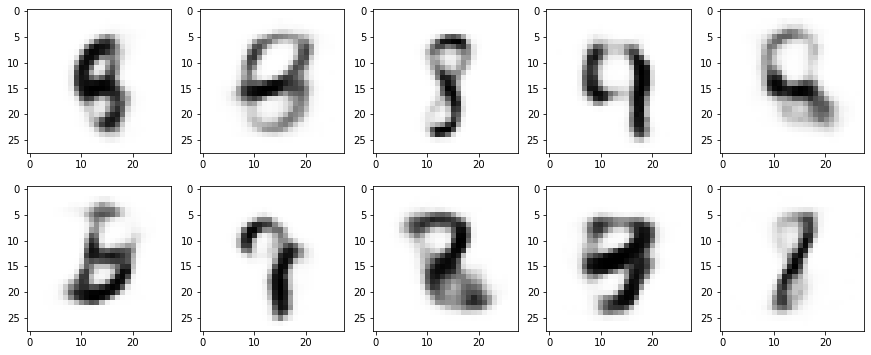

In [6]:
# Util function

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")


coding = torch.normal(mean=0, std=1, size=(10, 20))

outvals = model.decode(coding)

import matplotlib.pyplot as plt
ax = []
fig = plt.figure(figsize=(15, 6))

for i in range(10):
    ax.append(fig.add_subplot(2, 5, i+1))
    plot_image(outvals[i].detach().numpy())